## TE&NE Challenge Data Science Challenge


“The challenge will be to develop an improved time-series forecasting model using production data. You will then need to compare your implemented data-driven model with the conventional Arps decline model and highlight the differences.”

Prepared by Hector Klie, klieh@deepcast.ai, DeepCast.ai, https://www.deepcast.ai/

A DeepCast.ai contribution to TAMU Reservoir Engineer students - Play, learn and gain confidence :-)


In [13]:
# Jupyter commands used to auto-reload packages
%load_ext autoreload
%autoreload 2

# Import dependencies
import os
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit, OptimizeWarning

# Make plots larger
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Upload production data - There are 12 wells, the first 8 are measured in a monthly basis and the rest daily.  
path = 'C://Users//deepcast//Desktop//TAMU_TENE_Challenge'   # Define your own path 
ifile = 'Production.csv'
df_prod = pd.read_csv(os.path.join(path,ifile))
print(df_prod.head())

   Well ID   DAYS         OIL          GAS      WATER
0        1    0.0  630.868000  1157.095194  66.671992
1        1   31.0  552.874349  1444.594307  33.964977
2        1   61.0  556.648235  1160.644566   0.000000
3        1   92.0  440.915721  1238.730745   0.000000
4        1  122.0  340.278752  1029.317811   0.000000


In [15]:
# Arps-related statements

# Initial guess and bounds
initial_guess = [1000, 0.001, 0.5]
lower_bound = [1e-9, 1e-9, 0.]
upper_bound = [1e10, 10., 2.]

# Arps model for rates
def arps(t, qi, Di, b):
    if b < 1.e-5:  # Exponential
        return qi * np.exp(-np.maximum(Di * t, 1e-5))
    x = np.maximum(1.0 + b * Di * t, 1.0)
    q = qi * np.exp(-np.log(x) / b)
    return q

# Arps model for cums
def get_cum(t, qi, Di, b):
    qDi = qi / Di
    Dit = Di * t
    if b == 1.:  # Hyperbolic
        Q = qDi * np.log(1. + Dit)
    elif b > 0:
        Q = qDi * (1. - pow(1. + b * Dit, 1. - 1. / b)) / (1. - b)
    else:  # Exponential
        Q = qDi * (1. - np.exp(-Dit))
    if isinstance(Q, np.ndarray):
        if len(Q) > 1:
            return Q - Q[0]
        else:
            return Q
    return Q

In [16]:
# Fitting function based on https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
def least_squares_fit(f, t, q, initial_guess, lower_bound, upper_bound, tol=0.0001):
    try:
        fitting = curve_fit(f, t, q, initial_guess, bounds=(lower_bound, upper_bound), method='trf', ftol=tol*10, xtol=tol, gtol=tol*10)[0]  
    except (ValueError, RuntimeError, RuntimeWarning, OptimizeWarning, np.linalg.LinAlgError) as e:
        fitting = np.copy(initial_guess)
    return fitting

In [17]:
# Lets fit each production curve
well_ids = df_prod['Well ID'].unique()
phases = ['OIL', 'GAS', 'WATER']
fit_cols = ['Well ID', 'Phase', 'Initial Day', 'End Day', 'qi', 'Di', 'b']
df_params = pd.DataFrame(columns=fit_cols, data=[])

for wid in well_ids:
    print(f'Processing Well: {wid}')
    df1 = df_prod.groupby('Well ID').get_group(wid)
    t = df1['DAYS'].values
    fit = dict()
    for phase in phases:
        q = df1[phase]
        fitted_parms = least_squares_fit(arps, t, q, initial_guess, lower_bound, upper_bound, tol=0.0001)
        df_row_fit = pd.DataFrame(data=[[wid, phase, t[0], t[-1], *fitted_parms]], columns=fit_cols)
        df_params = pd.concat([df_params, df_row_fit], axis=0, ignore_index=True)

df_params.head()

Processing Well: 1
Processing Well: 2
Processing Well: 3
Processing Well: 4
Processing Well: 5
Processing Well: 6
Processing Well: 7
Processing Well: 8
Processing Well: 9
Processing Well: 10
Processing Well: 11
Processing Well: 12


,Well ID,Phase,Initial Day,End Day,qi,Di,b
0,1,OIL,0.0,5997.0,443.090743,1.012724e-09,0.010000
1,1,GAS,0.0,5997.0,1386.791868,1.220170e-03,0.948999
2,1,WATER,0.0,5997.0,11.821411,1.274535e-07,1.991628
3,2,OIL,0.0,14579.0,474.158589,5.136513e-05,0.000002
4,2,GAS,0.0,14579.0,343.251697,3.949121e-05,0.000014


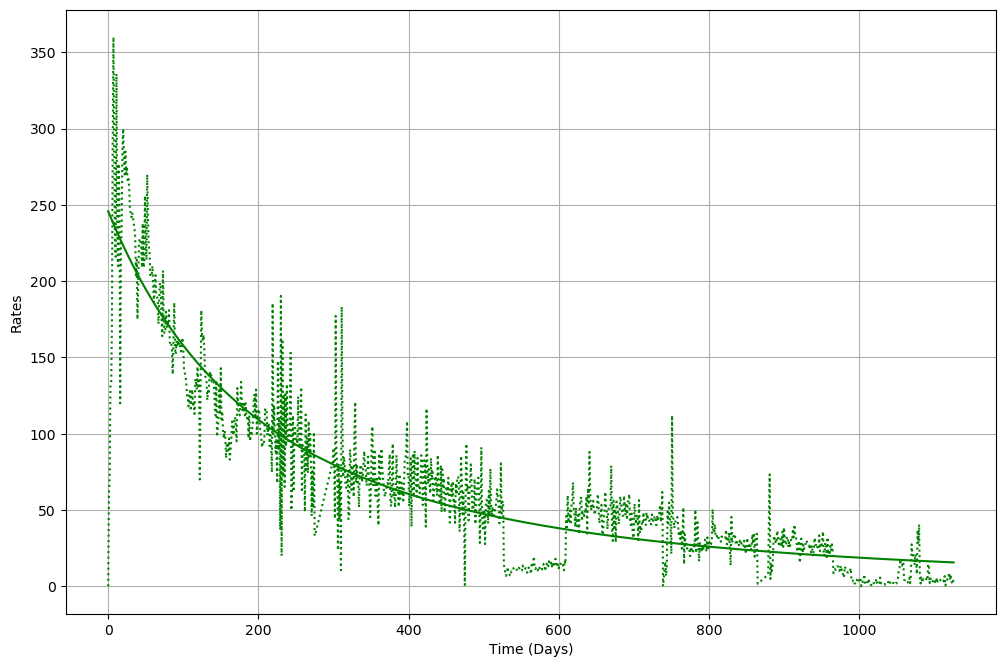

In [18]:
# We can visually inspect the fitting quality for a given well and phase - Feel free to pick any combination
wid, phase = 10, 'OIL'

t = df_prod.loc[df_prod['Well ID']==wid, 'DAYS'].values
q = df_prod.loc[df_prod['Well ID']==wid, phase].values
if phase == 'OIL':
    color = 'g'
elif phase == 'GAS':
    color = 'r'
elif phase == 'WATER':
    color = 'b'
plt.plot(t, q, color=color, linestyle='dotted')
df_params_row = df_params[np.logical_and(df_params['Well ID']==wid, df_params['Phase']==phase)]
qi, di, b =  df_params_row['qi'].values, df_params_row['Di'].values, df_params_row['b'].values
q_fit = arps(t, qi, di, b)
plt.plot(t, q_fit, color=color, linestyle='solid')
plt.xlabel('Time (Days)')
plt.ylabel('Rates')
plt.grid(True)
plt.show()

In [19]:
# Error functions

# Root Mean Square Error (RMSE) 
def rms_error(x, y):
    if isinstance(x, list):
        x, y = np.array(x), np.array(y)
    return np.sqrt(np.mean((x - y) ** 2))

# Coeffient of determination (R2)
def r2(x, y):
    if isinstance(x, list):
        x, y = np.array(x), np.array(y)
    r = stats.linregress(x, y)[2]
    return r if r > 0 else 0


In [20]:
# Given the above functions, we can now expand our df_params table with RMSE and R2 columns
rmse_values, r2_values = [], []

for i, series_params in df_params.iterrows():
    wid = series_params['Well ID']
    phase = series_params['Phase']
    t = df_prod.loc[df_prod['Well ID']==wid, 'DAYS'].values
    q = df_prod.loc[df_prod['Well ID']==wid, phase].values
    qi = series_params['qi']
    di = series_params['Di']
    b = series_params['b']
    q_fit = arps(t, qi, di, b)
    rmse_values.extend([rms_error(q, q_fit)])
    r2_values.extend([r2(q, q_fit)])

df_params['r2'] = r2_values
df_params['rmse'] = rmse_values    

df_params.head()

,Well ID,Phase,Initial Day,End Day,qi,Di,b,r2,rmse
0,1,OIL,0.0,5997.0,443.090743,1.012724e-09,0.010000,0.000000,157.115775
1,1,GAS,0.0,5997.0,1386.791868,1.220170e-03,0.948999,0.870460,151.289296
2,1,WATER,0.0,5997.0,11.821411,1.274535e-07,1.991628,0.000000,12.478697
3,2,OIL,0.0,14579.0,474.158589,5.136513e-05,0.000002,0.368502,198.765336
4,2,GAS,0.0,14579.0,343.251697,3.949121e-05,0.000014,0.222495,209.169943


In [26]:
# Now you can realize that there are bad fittings (feel compel to go back to visualize fittings with r2 values close to 0 or with relatively large rmse values)

# The Arps model tries to do its best job given its analytical flexibility (i.e., it can accommodate different declining trends such as hyperbolic and exponential) but data can be very noisy and show a non-monotonically decreasing behavior. 
# This spoils any intention to perform reliable forecasts on any dataset.

# This motivates the present data analytics challenge: Can we create a data-driven forecasting model that is more predictive and resilient to noise?

# To measure the quality of your proposed models, we will perform hindcasting analysis; that is, forecasts using a fraction of the historical data (i.e., after 6, 12 and 18 months of production). 
# Let's keep expanding the table RMS errors associated to each hindcasting.

year = 365 # days
hindcasts = [.5*year, year, 1.5*year]

hind_6_values, hind_12_values, hind_18_values = [], [], [] 
for _, series_params in df_params.iterrows():
    wid = series_params['Well ID']
    phase = series_params['Phase']
    t = df_prod.loc[df_prod['Well ID']==wid, 'DAYS'].values
    q = df_prod.loc[df_prod['Well ID']==wid, phase].values
    qi = series_params['qi']
    di = series_params['Di']
    b = series_params['b']
    for i in range(len(hindcasts)):
        idh = np.where(t <= hindcasts[i])[0]
        th, qh = t[idh], q[idh]
        fitted_parms = least_squares_fit(arps, th, qh, initial_guess, lower_bound, upper_bound, tol=0.0001)
        idf = np.where(t > hindcasts[i])[0]
        q_fit = arps(t[idf], *fitted_parms)
        if i == 0: 
            hind_6_values.extend([rms_error(q[idf], q_fit)])
        elif i == 1:
            hind_12_values.extend([rms_error(q[idf], q_fit)])
        elif i == 2:
            hind_18_values.extend([rms_error(q[idf], q_fit)])       
            
aver_hind = [(x + y + z)/3 for x, y, z in zip(hind_6_values, hind_12_values, hind_18_values)]
df_params['hind_6_months_rmse'] = hind_6_values 
df_params['hind_12_months_rmse'] = hind_12_values
df_params['hind_18_months_rmse'] = hind_18_values 
df_params['Average_hind_rmse']  = aver_hind

df_params.head()


,Well ID,Phase,Initial Day,End Day,qi,Di,b,r2,rmse,hind_6_months,hind_12_months,hind_18_months,hind_6_months_rmse,hind_12_months_rmse,hind_18_months_rmse,Average_hind_rmse
0,1,OIL,0.0,5997.0,443.090743,1.012724e-09,0.010000,0.000000,157.115775,375.227600,417.545267,403.819998,426.128979,417.545267,403.819998,415.831415
1,1,GAS,0.0,5997.0,1386.791868,1.220170e-03,0.948999,0.870460,151.289296,187.293633,269.814492,342.216755,187.293633,269.814492,342.216755,266.441627
2,1,WATER,0.0,5997.0,11.821411,1.274535e-07,1.991628,0.000000,12.478697,16.559614,16.848644,16.787390,16.559614,16.848644,16.787390,16.731882
3,2,OIL,0.0,14579.0,474.158589,5.136513e-05,0.000002,0.368502,198.765336,397.387470,397.227797,399.746192,397.387470,397.227797,399.746192,398.120486
4,2,GAS,0.0,14579.0,343.251697,3.949121e-05,0.000014,0.222495,209.169943,339.435320,341.636494,343.872379,339.435320,341.636494,343.872379,341.648065


In [ ]:
# So your objective is to decrease as much as possible the values shown in the last column for oil and gas - 36 points to achieve!
# Good luck!!!